# MNIST - MLP with Dropout Layer (multilayer perceptron)\
This notebook introduces the MNIST handwritten digits dataset and multilayer perceptron classifier. 

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import pickle, numpy as np, pandas as pd
import matplotlib.pyplot as plt

root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data')

## Load MNIST

In [2]:
def load_mnist_csv(mnist_data_folder, data_type):
    import pandas as pd, os
    file_name = os.path.join(mnist_data_folder, f'mnist_{data_type}.csv.zip')
    df = pd.read_csv(file_name)
    labels = df.values[:,0].astype(np.int8)
    images = df.values[:,1:].astype(np.uint8).reshape( (-1, 28, 28))
    return labels, images

train_labels, train_images = load_mnist_csv( os.path.join(data_folder, 'MNIST')  ,  'train')
test_labels, test_images = load_mnist_csv( os.path.join(data_folder, 'MNIST')  ,  'test')

In [3]:
print(f'Train set. X: {train_images.shape}, y: {train_labels.shape}' )
print(f'Test set. X: {test_images.shape}, y: {test_labels.shape}' )

Train set. X: (60000, 28, 28), y: (60000,)
Test set. X: (10000, 28, 28), y: (10000,)


### normalize the data

In [4]:
print(f"mean: {train_images.mean()}\nstd: {train_images.std()}")
print(f"min: {train_images.min()}\nmax: {train_images.max()}")

mean: 33.318421449829934
std: 78.56748998339742
min: 0
max: 255


In [5]:
# normalize to mean=0 and std=1
train_images_norm = (train_images-train_images.mean()) /train_images .std() 
test_images_norm = (test_images-train_images.mean()) /train_images.std()

In [6]:
print(f"mean: {train_images_norm.mean()}\nstd: {train_images_norm.std()}")
print(f"min: {train_images_norm.min()}\nmax: {train_images_norm.max()}")

mean: -7.144966402352823e-16
std: 1.0000000000000144
min: -0.424073894391569
max: 2.821543345689355


## Demonstrate Dropout Layer

In [35]:
import tensorflow as tf
dropout_layer = tf.keras.layers.Dropout(.3, input_shape=(7,))
input_data = np.random.rand(1, 7)
output_data = dropout_layer(input_data, training=True)
input_data, output_data

(array([[0.89108206, 0.79587009, 0.52702267, 0.07469024, 0.86332731,
         0.17840531, 0.23082562]]),
 <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[1.2729744, 1.1369573, 0.7528895, 0.       , 1.2333248, 0.       ,
         0.3297509]], dtype=float32)>)

note that in training mode, the values change due to re-normalization!

In [8]:
dropout_layer(input_data, training=True), dropout_layer(input_data, training=True), dropout_layer(input_data, training=True)

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[0.        , 1.208364  , 0.        , 0.41822523, 0.        ,
         0.81462306, 1.1815991 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[0.25907937, 1.208364  , 0.        , 0.        , 1.2153755 ,
         0.81462306, 1.1815991 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[0.25907937, 0.        , 0.30495995, 0.        , 1.2153755 ,
         0.81462306, 1.1815991 ]], dtype=float32)>)

dropout preserves the overal sum of outputs, which are scaled with $\large \frac {1}{(1−𝑝)}$

In [36]:
np.sum(dropout_layer(input_data, training=True)) , np.sum(input_data)

(3.6432564, 3.561223299524782)

evaluation mode: dropout layer is disabled. 

In [10]:
dropout_layer(input_data, training=False), dropout_layer(input_data, training=False), dropout_layer(input_data, training=False)


(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[0.18135555, 0.84585476, 0.21347196, 0.29275766, 0.85076284,
         0.57023615, 0.8271194 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[0.18135555, 0.84585476, 0.21347196, 0.29275766, 0.85076284,
         0.57023615, 0.8271194 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[0.18135555, 0.84585476, 0.21347196, 0.29275766, 0.85076284,
         0.57023615, 0.8271194 ]], dtype=float32)>)

### Demonstrate normalization

In [11]:
dropout_layer = tf.keras.layers.Dropout(.9, input_shape=(70000,)) #drops 90% of the data
input_data = np.abs(np.random.randn(5, 70000))
output_data = dropout_layer(input_data, training=True)
output_data = output_data.numpy()
input_data.sum(1),output_data.sum(1), (output_data==0).sum(1)

(array([55892.14700071, 55753.43878434, 55905.67355666, 55903.7653656 ,
        55861.03301174]),
 array([55629.074, 55917.55 , 56042.156, 55195.203, 57304.613],
       dtype=float32),
 array([63068, 62974, 62941, 63048, 62874]))

## Multilayer perceptron  (MLP) network 
We will create a simple MLP network with the following layout
- Input layer: 784 
- Hidden layer 1: 512 neurons with ReLU Activation
- dropout layer 1: p=0.5
- Hidden layer 2: 512 neurons with ReLU Activation
- dropout layer 2: p=0.5
- Outut layer: 10 with Log Softmax Activation


<ul>
    <li>
Softmax  - Rescales input to  resemble probability scores <br>  
        $\large Sofotmax(x_i) = \frac{exp(x_i)}{\sum_j{exp(x_j)}}$ <br>
    </li>
        <li>
    LogSoftmax  - Rescales input to  resemble probability scores <br>  
        $\large LogSofotmax(x_i) = log(\frac{exp(x_i)}{\sum_j{exp(x_j)}})$ <br>
    </li>
</ul>    

### Define the Neural Network  Model

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(512, input_dim=28*28, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(450, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid'))

### Compile the model

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Bring the data into a proper format
- images to vectors: $Nx28x28 -> Nx784$
- labels to one-hot encoding: $N -> N x 10$
  > use ```pd.get_dummies``` or ```keras.utils.to_categorical```

In [14]:
train_images_norm = train_images_norm.reshape(-1, 28*28) # 60,000 x 784
train_labels_onehot = pd.get_dummies(train_labels).values # 60,000 x 10

# split train set into train and validation
train_validation_split = np.random.rand(len(train_images_norm))<0.2 

valid_images_norm = train_images_norm[train_validation_split]     # ~ 12,000 x 784
valid_labels_onehot = train_labels_onehot[train_validation_split] # ~ 12,000 x 10

train_images_norm_fit = train_images_norm[~train_validation_split] # ~48,000 x 784
train_labels_onehot_fit = train_labels_onehot[~train_validation_split] # ~48,000 x 10

test_images_norm = test_images_norm.reshape(-1, 28*28) # 10,000 x 784
test_labels_onehot = pd.get_dummies(test_labels).values  # 10,000 x 10

### Example - computing model. 

In [15]:
model(train_images_norm[:3]).shape

TensorShape([3, 10])

### Train the model 

In [16]:
history = model.fit(train_images_norm_fit, train_labels_onehot_fit, 
    validation_data=(valid_images_norm, valid_labels_onehot), 
    epochs=50, batch_size=50, verbose=2)

Epoch 1/50
961/961 - 15s - loss: 0.4046 - accuracy: 0.8753 - val_loss: 0.1769 - val_accuracy: 0.9483 - 15s/epoch - 15ms/step
Epoch 2/50
961/961 - 15s - loss: 0.2260 - accuracy: 0.9336 - val_loss: 0.1290 - val_accuracy: 0.9630 - 15s/epoch - 15ms/step
Epoch 3/50
961/961 - 15s - loss: 0.1930 - accuracy: 0.9431 - val_loss: 0.1176 - val_accuracy: 0.9652 - 15s/epoch - 16ms/step
Epoch 4/50
961/961 - 15s - loss: 0.1662 - accuracy: 0.9506 - val_loss: 0.1107 - val_accuracy: 0.9670 - 15s/epoch - 15ms/step
Epoch 5/50
961/961 - 15s - loss: 0.1547 - accuracy: 0.9548 - val_loss: 0.1097 - val_accuracy: 0.9667 - 15s/epoch - 16ms/step
Epoch 6/50
961/961 - 15s - loss: 0.1504 - accuracy: 0.9555 - val_loss: 0.1093 - val_accuracy: 0.9670 - 15s/epoch - 16ms/step
Epoch 7/50
961/961 - 15s - loss: 0.1415 - accuracy: 0.9583 - val_loss: 0.1046 - val_accuracy: 0.9704 - 15s/epoch - 16ms/step
Epoch 8/50
961/961 - 14s - loss: 0.1393 - accuracy: 0.9598 - val_loss: 0.0931 - val_accuracy: 0.9731 - 14s/epoch - 15ms/step


### Test the model
- against train set

In [17]:
_, accuracy = model.evaluate(train_images_norm_fit, train_labels_onehot_fit)
_, accuracy = model.evaluate(valid_images_norm, valid_labels_onehot)


375/375 [==============================] - 1s 2ms/step - loss: 0.1053 - accuracy: 0.9805


- against test set

In [18]:
_, accuracy = model.evaluate(test_images_norm, test_labels_onehot)

313/313 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.9805


#### manually compute prediction accuracy (fraction of correctly predicted digits)

In [19]:
predicted_labels = np.argmax(model(train_images_norm), axis=1)
(predicted_labels == train_labels).mean()

0.9932333333333333

In [20]:
predicted_labels = np.argmax(model.predict(test_images_norm), axis=1)
(predicted_labels == test_labels).mean()

313/313 [==============================] - 1s 2ms/step


0.9805

- compute and display confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=test_labels, y_pred=predicted_labels)
conf_mat

array([[ 972,    1,    0,    0,    0,    1,    2,    1,    3,    0],
       [   0, 1122,    1,    3,    0,    3,    3,    0,    3,    0],
       [   2,    0, 1016,    2,    1,    0,    0,    6,    5,    0],
       [   0,    0,    1,  996,    0,    3,    0,    5,    2,    3],
       [   0,    1,    1,    0,  965,    0,    4,    1,    3,    7],
       [   2,    0,    0,    9,    1,  872,    1,    0,    6,    1],
       [   7,    2,    0,    0,    2,    4,  939,    0,    4,    0],
       [   0,    5,    6,    0,    1,    0,    0, 1012,    0,    4],
       [   2,    1,    1,    3,    7,    3,    0,    5,  949,    3],
       [   2,    4,    0,    5,   20,    3,    1,    6,    6,  962]],
      dtype=int64)

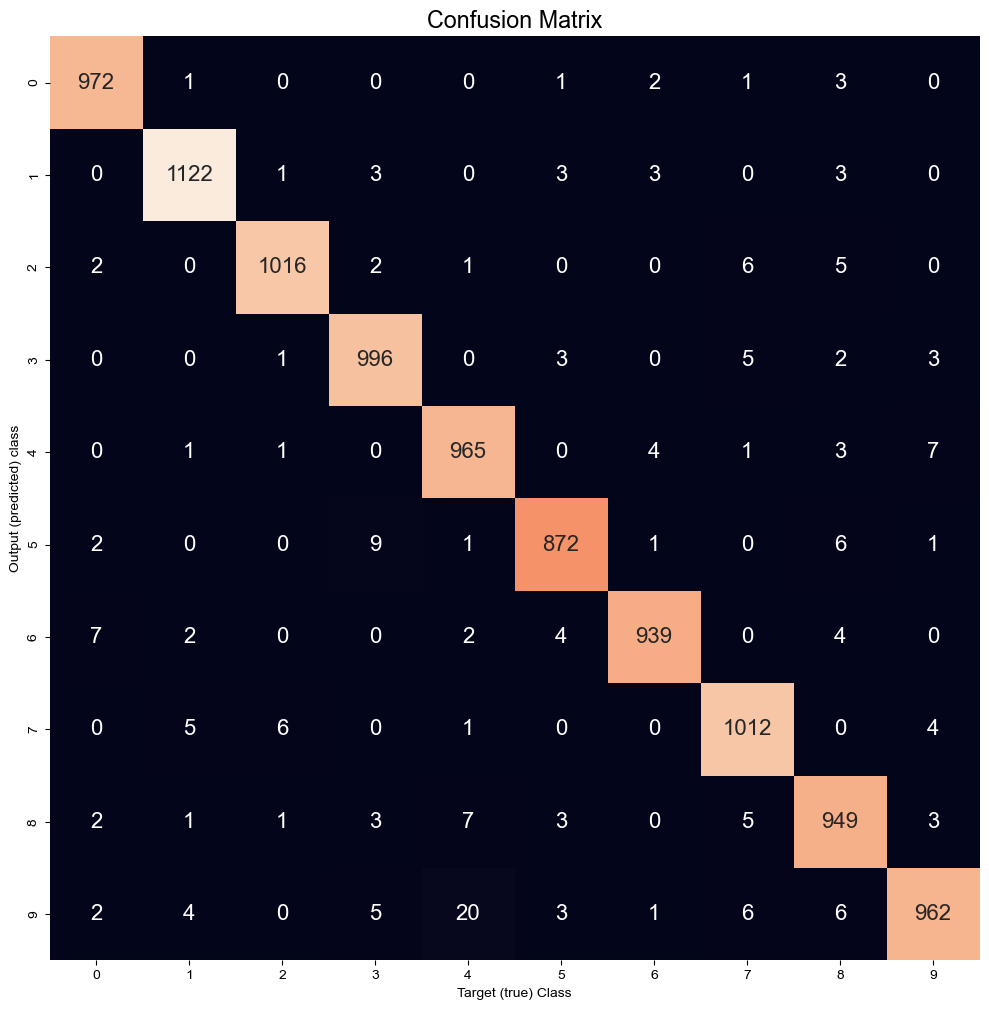

In [22]:
import seaborn as sn

#plot_confusion_matrix(estimator=model, X=test_images_norm, y_true=test_labels )
plt.subplots(figsize=(12,12))
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False) # font size
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show()


### Explore the model parameters
Expected number of model parameters: <br>
- 1st layer: $784 \cdot 512 + 512 = 401,920$
- 2st layer: $512 \cdot 450 + 450 = 230,850$
- 3rd layer: $450 \cdot 10 + 10 = 4,510 $
---
Total number of expected parameters: $401920+230850+4510=637,280$

In [23]:
model.count_params()

637280

In [24]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 450)               230850    
                                                                 
 dropout_3 (Dropout)         (None, 450)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                4510      
                                                                 
Total params: 637,280
Trainable params: 637,280
Non-trainable params: 0
_________________________________________________________________


## Run & display predictions
- make predictions

In [25]:
predicted_label = np.argmax( model(test_images_norm.reshape(-1, 28*28)) , axis=1) 

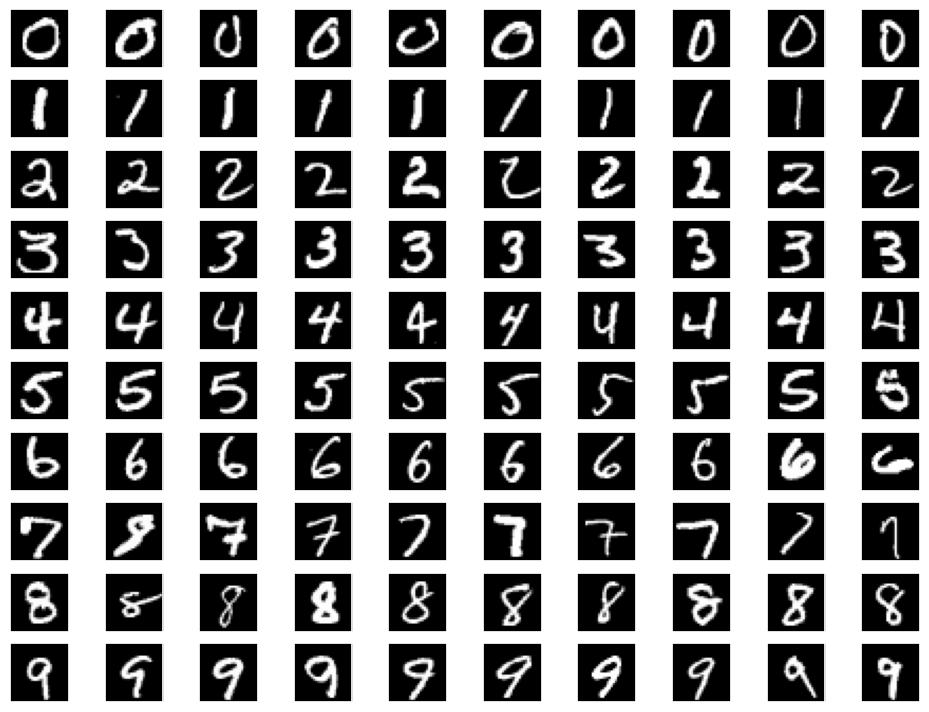

In [26]:
number_of_coulmns = 10

fig, ax = plt.subplots(ncols =number_of_coulmns, nrows=10, figsize=(12,9))


for digit in range(10):
    # select only images labeled with the current *digit*
    image_subset = test_images[predicted_label==digit]
    # draw *number_of_coulmns* random images
    image_samples = np.random.randint(low=0, high= len(image_subset), size=(number_of_coulmns, ))
    for col_index, image_index in enumerate(image_samples): 
        ax[digit, col_index].imshow(image_subset[image_index], cmap='gray')        
        ax[digit, col_index].set_xticks([]);ax[digit, col_index].set_yticks([]); 
        
        predicted_digit = np.argmax(model(image_subset[image_index].reshape(1,-1)))

## Visualize effect of dropout layer

In [27]:
def generate_model(dropout):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout

    model = Sequential()
    model.add(Dense(512, input_dim=28*28, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(450, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='sigmoid'))
    return model

models={}
for dropout in [0, 0.3, 0.6, 0.9]:   
    model_file_name = os.path.join(data_folder, f"mnist_dropout_{dropout:2.2f}".replace('.','_'))
    
    if not os.path.isdir(model_file_name+'.model'):    
        model = generate_model(dropout)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_images_norm_fit, train_labels_onehot_fit,  
                            validation_data=(valid_images_norm, valid_labels_onehot), 
                            epochs=50, batch_size=100, verbose=0)
        print(f"Trained model for drooput {dropout}")
        

        model.save(model_file_name + '.model')
        
        hist_df = pd.DataFrame(history.history) 
        hist_df.to_csv(model_file_name + '.history.csv')
    models[dropout] = {
        'dropout': dropout,
        'history': pd.read_csv(model_file_name + '.history.csv', index_col=0),
        'model': tf.keras.models.load_model(model_file_name + '.model')        
    }

In [37]:
models

{0: {'dropout': 0,
  'history':         loss  accuracy  val_loss  val_accuracy
  0   0.207288  0.935933  0.123694      0.963368
  1   0.085633  0.972692  0.108740      0.968672
  2   0.057324  0.981579  0.108381      0.968921
  3   0.044632  0.984979  0.097886      0.973562
  4   0.033431  0.988818  0.100949      0.975303
  5   0.027891  0.990716  0.116371      0.972816
  6   0.028613  0.990257  0.116709      0.972899
  7   0.025891  0.991384  0.107066      0.976877
  8   0.021418  0.992573  0.114176      0.976297
  9   0.020317  0.993470  0.123360      0.974308
  10  0.014953  0.995181  0.130999      0.975303
  11  0.021013  0.993449  0.113323      0.976960
  12  0.017683  0.994638  0.134268      0.977126
  13  0.014592  0.995160  0.127725      0.976877
  14  0.017021  0.994638  0.160516      0.976048
  15  0.013306  0.995974  0.135625      0.978700
  16  0.011161  0.996433  0.133263      0.978286
  17  0.012737  0.996141  0.161809      0.974639
  18  0.018246  0.994764  0.137656     

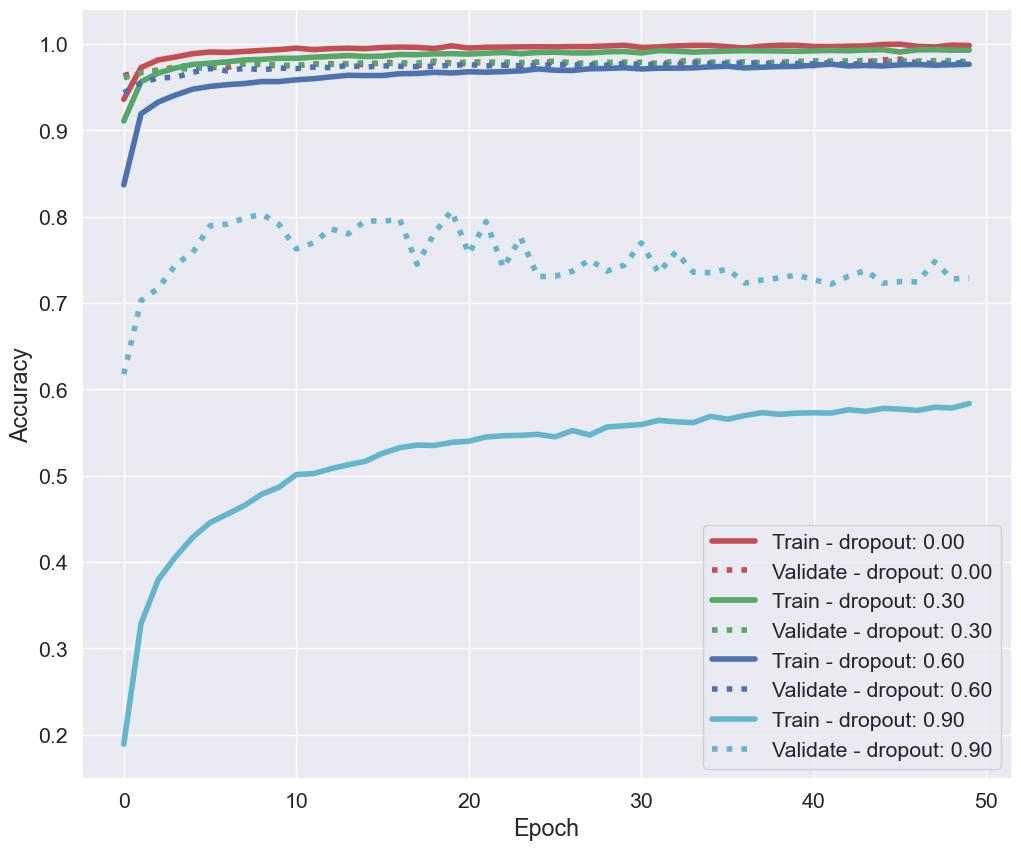

In [28]:
plt.subplots(figsize=(12,10))
colors = ['r', 'g', 'b', 'c']
for i, dropout in enumerate(models.keys()):
    history = models[dropout]['history']
    plt.plot(history['accuracy'],'-' + colors[i], label=f'Train - dropout: {dropout:2.2f}' , linewidth=4)
    plt.plot(history['val_accuracy'],':' + colors[i], label=f'Validate - dropout: {dropout:2.2f}', linewidth=4 )
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Accuracy');

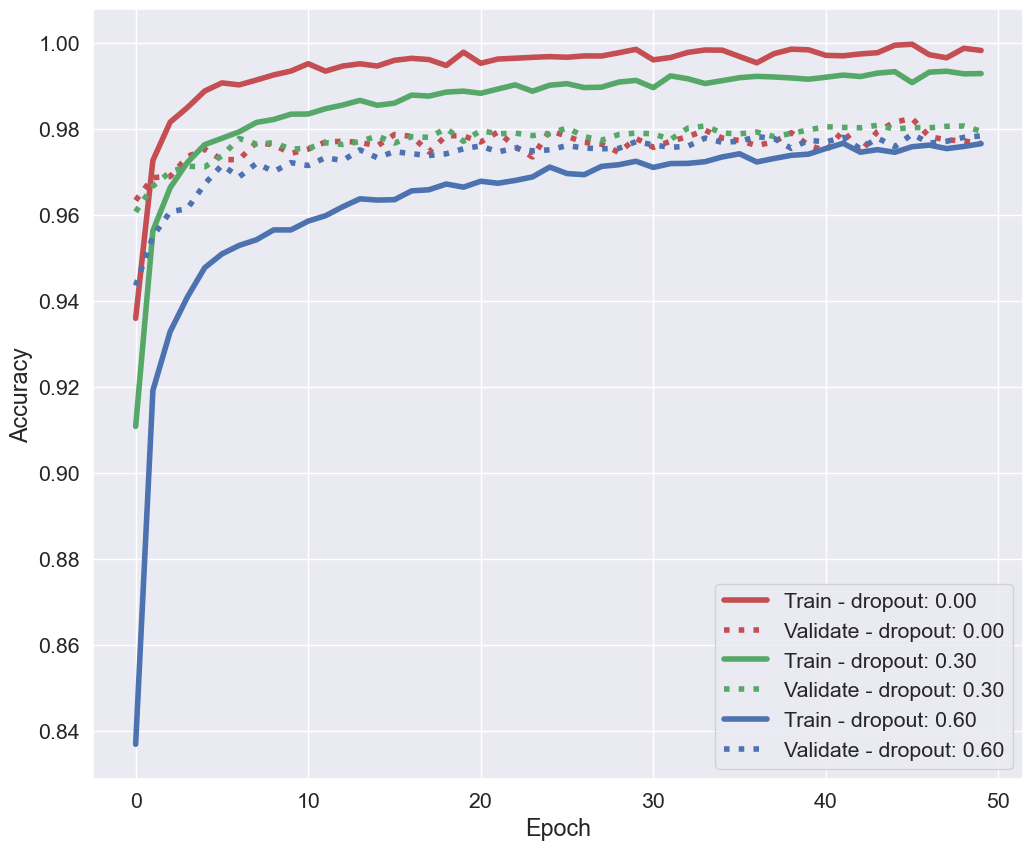

In [29]:
plt.subplots(figsize=(12,10))
colors = ['r', 'g', 'b', 'c']
for i, dropout in enumerate(models.keys()):
    if dropout<0.8:
        history = models[dropout]['history']
        plt.plot(history['accuracy'],'-' + colors[i], label=f'Train - dropout: {dropout:2.2f}' , linewidth=4)
        plt.plot(history['val_accuracy'],':' + colors[i], label=f'Validate - dropout: {dropout:2.2f}', linewidth=4 )
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Accuracy');